### Denoising Autoencoders And Where To Find Them (10 pts)

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [1]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py -O lfw_dataset.py
!pip install Image Pillow==5.1.0 scipy==1.1.0

import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


device = torch.device("cuda") # or you print here you favorite gpu card
#torch.set_default_tensor_type(torch.cuda.FloatTensor) 
# uses cuda floats by default
print(device)

--2021-11-25 05:58:28--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3056 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.98K  --.-KB/s    in 0s      

2021-11-25 05:58:28 (17.7 MB/s) - ‘lfw_dataset.py’ saved [3056/3056]

cuda


In [2]:
BATCH_SIZE = 32

In [3]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)
X = X.transpose([0, 3, 1, 2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [4]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [52]:
print(img_shape)

(3, 38, 38)


X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


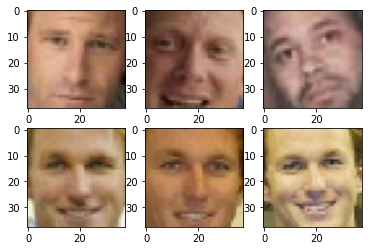

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [7]:
class Reshape(nn.Module):
    """ this class corresponds to torch.reshape function and may be used as a reshape layer """
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, input):
        return input.reshape(*self.shape)

In [8]:
class PCAAutoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=50):
        super(PCAAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), Reshape(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction) ** 2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [9]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [10]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].cuda(device=device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [11]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

370it [00:01, 304.68it/s]


1, Train loss: 0.1137746305309132, Test loss: 0.024344041268855903


370it [00:01, 333.66it/s]


2, Train loss: 0.02328944853840144, Test loss: 0.023134911087099856


370it [00:01, 329.40it/s]


3, Train loss: 0.022896463429352698, Test loss: 0.022922251225739758


370it [00:01, 334.61it/s]


4, Train loss: 0.022631023788484795, Test loss: 0.022616240073071312


370it [00:01, 334.04it/s]


5, Train loss: 0.02230909639686438, Test loss: 0.02221752884463709


370it [00:01, 338.23it/s]


6, Train loss: 0.021728475622830562, Test loss: 0.02171924800534377


370it [00:01, 336.02it/s]


7, Train loss: 0.020704799908103665, Test loss: 0.02006546730354069


370it [00:01, 338.43it/s]


8, Train loss: 0.019235432208840157, Test loss: 0.01855961371121924


370it [00:01, 337.82it/s]


9, Train loss: 0.017625793542481883, Test loss: 0.01719193606002088


370it [00:01, 329.48it/s]


10, Train loss: 0.0163807644904292, Test loss: 0.01614027334835037


370it [00:01, 331.75it/s]


11, Train loss: 0.015034874228273246, Test loss: 0.014661764313901518


370it [00:01, 330.59it/s]


12, Train loss: 0.013738668162454771, Test loss: 0.012996480977383323


370it [00:01, 308.13it/s]


13, Train loss: 0.012637336320250837, Test loss: 0.01260770389534447


370it [00:01, 303.03it/s]


14, Train loss: 0.011675818752721109, Test loss: 0.011487629132406398


370it [00:01, 302.80it/s]


15, Train loss: 0.010952505921006103, Test loss: 0.011075833628382202


370it [00:01, 306.81it/s]


16, Train loss: 0.010318580491692311, Test loss: 0.011061233815190774


370it [00:01, 306.74it/s]


17, Train loss: 0.00969897880722838, Test loss: 0.009450836830668176


370it [00:01, 301.67it/s]


18, Train loss: 0.009045571587482912, Test loss: 0.008837839400848094


370it [00:01, 301.28it/s]


19, Train loss: 0.008690061091751206, Test loss: 0.008594643560395849


370it [00:01, 304.09it/s]


20, Train loss: 0.008341674281606424, Test loss: 0.00823137777507007


370it [00:01, 303.86it/s]


21, Train loss: 0.008065849005096786, Test loss: 0.008546052202498895


370it [00:01, 300.48it/s]


22, Train loss: 0.00759745458435422, Test loss: 0.007574818054952828


370it [00:01, 300.45it/s]


23, Train loss: 0.007602265771843947, Test loss: 0.007439285023455712


370it [00:01, 306.24it/s]


24, Train loss: 0.007359435689347192, Test loss: 0.007179117483086443


370it [00:01, 307.10it/s]


25, Train loss: 0.007122944001768711, Test loss: 0.007013979874222382


370it [00:01, 300.83it/s]


26, Train loss: 0.0069364438334109085, Test loss: 0.006834549805165894


370it [00:01, 303.38it/s]


27, Train loss: 0.006819598105302185, Test loss: 0.007096096972190842


370it [00:01, 305.40it/s]


28, Train loss: 0.0066891253535208695, Test loss: 0.007132902288766798


370it [00:01, 299.33it/s]


29, Train loss: 0.0066547792351461955, Test loss: 0.006462550571180077


370it [00:01, 302.78it/s]


30, Train loss: 0.006424817207902069, Test loss: 0.006376500496225328


370it [00:01, 305.92it/s]


31, Train loss: 0.00636116810322649, Test loss: 0.006520926840998803


370it [00:01, 301.19it/s]


32, Train loss: 0.006367517452504308, Test loss: 0.0062242997348175635


370it [00:01, 300.42it/s]


33, Train loss: 0.006246558190702091, Test loss: 0.0063019865096988455


370it [00:01, 299.46it/s]


34, Train loss: 0.00622548196571817, Test loss: 0.006294558443962842


370it [00:01, 306.47it/s]


35, Train loss: 0.006159980650367744, Test loss: 0.006364823436403029


370it [00:01, 299.52it/s]


36, Train loss: 0.006089977071236071, Test loss: 0.007213931184971997


370it [00:01, 307.48it/s]


37, Train loss: 0.005996821592267111, Test loss: 0.006052941161725273


370it [00:01, 300.44it/s]


38, Train loss: 0.0059749538032666735, Test loss: 0.006108356974554318


370it [00:01, 299.87it/s]


39, Train loss: 0.005993476099994041, Test loss: 0.005882303859873044


370it [00:01, 305.27it/s]


40, Train loss: 0.005898978845150098, Test loss: 0.005944489756739009


In [12]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

0.0059421038271710155


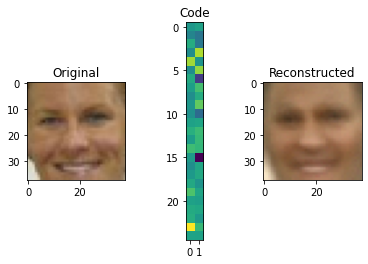

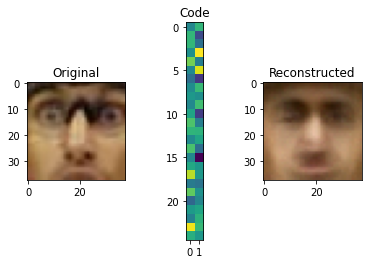

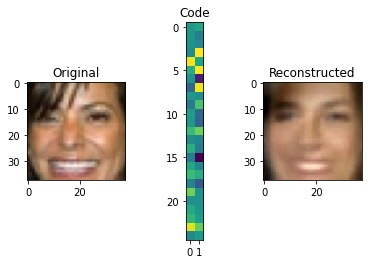

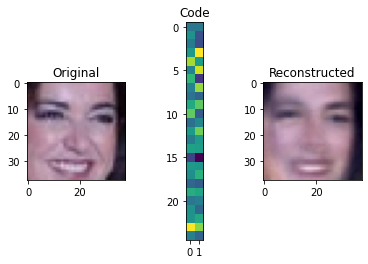

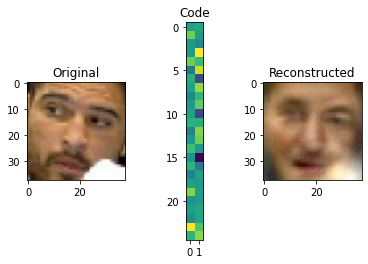

In [13]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [15]:
class DeepAutoencoder(nn.Module):
    def __init__(self, code_size=50):
        super(DeepAutoencoder, self).__init__()
        self.enc = nn.Sequential(nn.Conv2d(3, 16, 3, 1, padding='same'),
                                 nn.LayerNorm([16, 38, 38]),
                                 nn.Conv2d(16, 16, 3, 1, padding='same'),
                                 nn.LayerNorm([16, 38, 38]),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2, 2),
                                 Reshape(-1, 16 * 19 * 19),
                                 nn.Linear(16 * 19 * 19, 700),
                                 nn.ReLU(),
                                 nn.Linear(700, code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, 700),
                                 nn.ReLU(),
                                 nn.Linear(700, 16 * 19 * 19),
                                 nn.ReLU(),
                                 Reshape(-1, 16, 19, 19),
                                 nn.UpsamplingNearest2d(scale_factor=2),
                                 nn.ConvTranspose2d(16, 16, 3, 1, padding=1),
                                 nn.LayerNorm([16, 38, 38]),
                                 nn.ConvTranspose2d(16, 3, 3, 1, padding=1))
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [16]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = DeepAutoencoder(code_size).double().to(device)
    encoder_out = model.enc(help_tensor.cuda(device))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:] == torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:] == img_shape,   "decoder must output an image of valid shape"

    assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [17]:
aenc_deep = DeepAutoencoder()
train(aenc_deep, X_train_tensor, X_test_tensor, num_epoch=50)

370it [00:12, 29.43it/s]


1, Train loss: 0.04264473465807502, Test loss: 0.016080401874685336


370it [00:12, 29.54it/s]


2, Train loss: 0.01408740995011615, Test loss: 0.012531038610876191


370it [00:12, 29.46it/s]


3, Train loss: 0.011283615480434385, Test loss: 0.010572744844528978


370it [00:12, 29.46it/s]


4, Train loss: 0.009747129698620589, Test loss: 0.009321467879818949


370it [00:12, 29.62it/s]


5, Train loss: 0.008731489888875234, Test loss: 0.008534019507018657


370it [00:12, 29.63it/s]


6, Train loss: 0.008039958685203085, Test loss: 0.008226826040261984


370it [00:12, 29.61it/s]


7, Train loss: 0.0075233267199175235, Test loss: 0.007345653884003743


370it [00:12, 29.49it/s]


8, Train loss: 0.007065036650128964, Test loss: 0.00702018699584684


370it [00:12, 29.67it/s]


9, Train loss: 0.006707188397790876, Test loss: 0.006721749457825796


370it [00:12, 29.63it/s]


10, Train loss: 0.006470850447579722, Test loss: 0.006449390205274174


370it [00:12, 29.64it/s]


11, Train loss: 0.0061700936033382905, Test loss: 0.006247617237104475


370it [00:12, 29.55it/s]


12, Train loss: 0.005988530940543535, Test loss: 0.006254937840882829


370it [00:12, 29.70it/s]


13, Train loss: 0.005852838538077499, Test loss: 0.005984571660598832


370it [00:12, 29.70it/s]


14, Train loss: 0.005743497542972913, Test loss: 0.005977275571745368


370it [00:12, 29.66it/s]


15, Train loss: 0.005663600807337307, Test loss: 0.005718095815651262


370it [00:12, 29.56it/s]


16, Train loss: 0.005529367083693269, Test loss: 0.005806744158844045


370it [00:12, 29.68it/s]


17, Train loss: 0.005506760019609497, Test loss: 0.005716765440717912


370it [00:12, 29.62it/s]


18, Train loss: 0.0054484536879949265, Test loss: 0.0056485600185860445


370it [00:12, 29.66it/s]


19, Train loss: 0.005352476877533995, Test loss: 0.0059458196549400716


370it [00:12, 29.54it/s]


20, Train loss: 0.005300850003874379, Test loss: 0.005576209394004631


370it [00:12, 29.67it/s]


21, Train loss: 0.005230130514675229, Test loss: 0.0055917465890248244


370it [00:12, 29.58it/s]


22, Train loss: 0.005166880443859231, Test loss: 0.006032619306563738


370it [00:12, 29.59it/s]


23, Train loss: 0.0051165848218957, Test loss: 0.005501237629690551


370it [00:12, 29.46it/s]


24, Train loss: 0.005100605671498376, Test loss: 0.0055090652437569014


370it [00:12, 29.62it/s]


25, Train loss: 0.005044927607321044, Test loss: 0.005499959813638843


370it [00:12, 29.62it/s]


26, Train loss: 0.004973110926997086, Test loss: 0.005512823766665293


370it [00:12, 29.67it/s]


27, Train loss: 0.004954169700362606, Test loss: 0.005444904913820494


370it [00:12, 29.46it/s]


28, Train loss: 0.004888517959546475, Test loss: 0.0054250327660995525


370it [00:12, 29.63it/s]


29, Train loss: 0.004872125221938958, Test loss: 0.0054786431231349355


370it [00:12, 29.63it/s]


30, Train loss: 0.004804216519841305, Test loss: 0.005428805846623929


370it [00:12, 29.60it/s]


31, Train loss: 0.004765365170945075, Test loss: 0.0054155155246485166


370it [00:12, 29.54it/s]


32, Train loss: 0.004740556139249703, Test loss: 0.005423966456970346


370it [00:12, 29.69it/s]


33, Train loss: 0.004699677904039309, Test loss: 0.005478338916849309


370it [00:12, 29.57it/s]


34, Train loss: 0.004667569872144086, Test loss: 0.0056236817772833195


370it [00:12, 29.61it/s]


35, Train loss: 0.00464122914572492, Test loss: 0.0054303305304248635


370it [00:12, 29.51it/s]


36, Train loss: 0.004594799157811567, Test loss: 0.0055159027502592215


370it [00:12, 29.62it/s]


37, Train loss: 0.004574291780251246, Test loss: 0.005332842722972559


370it [00:12, 29.62it/s]


38, Train loss: 0.004533265777358553, Test loss: 0.005449701132459888


370it [00:12, 29.56it/s]


39, Train loss: 0.004501936488554982, Test loss: 0.005418206027088839


370it [00:12, 29.48it/s]


40, Train loss: 0.004465562135802312, Test loss: 0.00545922442477298


370it [00:12, 29.69it/s]


41, Train loss: 0.004456344930343265, Test loss: 0.005422228590258617


370it [00:12, 29.58it/s]


42, Train loss: 0.004406084203112398, Test loss: 0.0053420401428753


370it [00:12, 29.56it/s]


43, Train loss: 0.0043732570653924425, Test loss: 0.005436227342384689


370it [00:12, 29.54it/s]


44, Train loss: 0.0043518912559345575, Test loss: 0.005382031396431496


370it [00:12, 29.59it/s]


45, Train loss: 0.0043322895791314655, Test loss: 0.005453957464334321


370it [00:12, 29.60it/s]


46, Train loss: 0.004293679880246527, Test loss: 0.005363526668649994


370it [00:12, 29.68it/s]


47, Train loss: 0.004267597535237761, Test loss: 0.005664808367602807


370it [00:12, 29.50it/s]


48, Train loss: 0.004249479962660271, Test loss: 0.005426620124055164


370it [00:12, 29.64it/s]


49, Train loss: 0.004208222086117016, Test loss: 0.0054682358178478494


370it [00:12, 29.65it/s]


50, Train loss: 0.004190003100867037, Test loss: 0.005372674959499849


Training may take long, it's okay.

Final MSE: 0.0054404144649733265


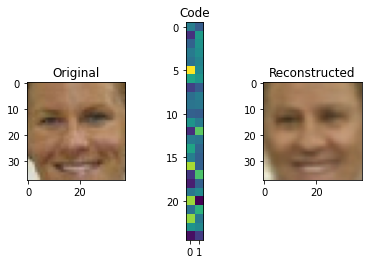

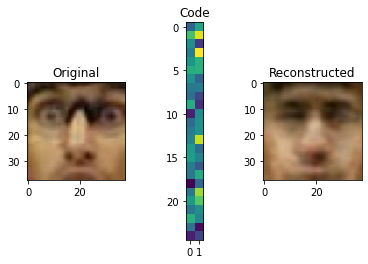

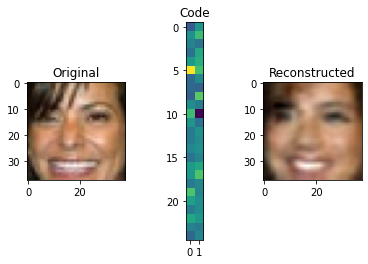

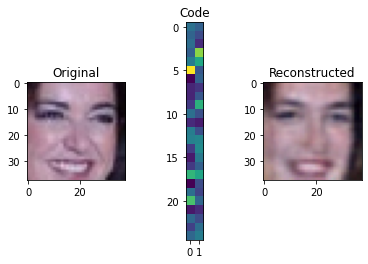

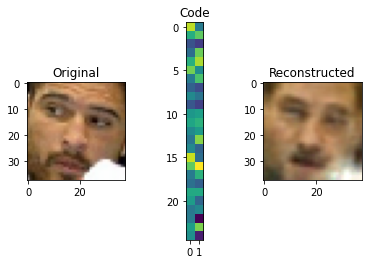

In [18]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)

assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 50, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 50 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [19]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    batch, height, width, channels = X.size()
    noise = sigma * torch.randn(batch, height, width, channels)
        
    return X + noise

def apply_gaussian_noise_sample(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    height, width, channels = X.size()
    noise = sigma * torch.randn(height, width, channels)
        
    return X + noise
    

In [20]:
#noise tests
theoretical_std = (X[:100].std() ** 2 + 0.5 ** 2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

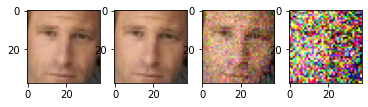

In [21]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [22]:
aenc = DeepAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)

370it [00:13, 28.42it/s]


1, Train loss: 0.067618313677916, Test loss: 0.024644033182577896


370it [00:12, 28.84it/s]


2, Train loss: 0.015088970245657805, Test loss: 0.017832908331008607


370it [00:12, 28.88it/s]


3, Train loss: 0.011747798451336826, Test loss: 0.017991151097259763


370it [00:12, 28.88it/s]


4, Train loss: 0.01033233089816724, Test loss: 0.013028604601540808


370it [00:12, 28.75it/s]


5, Train loss: 0.009204220312976219, Test loss: 0.01315342097352373


370it [00:12, 28.94it/s]


6, Train loss: 0.008480422082491695, Test loss: 0.0092860039954372


370it [00:12, 28.91it/s]


7, Train loss: 0.007903474795511529, Test loss: 0.00933841832359559


370it [00:12, 28.89it/s]


8, Train loss: 0.007503899310443234, Test loss: 0.008928978953095324


370it [00:12, 28.73it/s]


9, Train loss: 0.0071606369087497965, Test loss: 0.007737243639104395


370it [00:12, 28.97it/s]


10, Train loss: 0.006854574418873957, Test loss: 0.007861043152996086


370it [00:12, 28.93it/s]


11, Train loss: 0.0066151656266099515, Test loss: 0.007683270682759106


370it [00:12, 28.90it/s]


12, Train loss: 0.006469828124644775, Test loss: 0.0071111554865496565


370it [00:12, 28.79it/s]


13, Train loss: 0.006289161341927537, Test loss: 0.006570398476315106


370it [00:12, 28.78it/s]


14, Train loss: 0.006170469267635398, Test loss: 0.00669052295381289


370it [00:12, 28.96it/s]


15, Train loss: 0.006062917721823089, Test loss: 0.007038796101374137


370it [00:12, 28.93it/s]


16, Train loss: 0.005953996487404943, Test loss: 0.006327067896354207


370it [00:12, 28.78it/s]


17, Train loss: 0.005850085673700389, Test loss: 0.006860718199153124


370it [00:12, 28.92it/s]


18, Train loss: 0.005758288289905671, Test loss: 0.006014106835114249


370it [00:12, 28.94it/s]


19, Train loss: 0.0057203288327007966, Test loss: 0.005738343231187957


370it [00:12, 28.89it/s]


20, Train loss: 0.005650237809855168, Test loss: 0.00594296129404763


370it [00:12, 28.71it/s]


21, Train loss: 0.005576969168691964, Test loss: 0.005805155174345108


370it [00:12, 28.97it/s]


22, Train loss: 0.00551181643270816, Test loss: 0.005894278969527663


370it [00:12, 28.89it/s]


23, Train loss: 0.00546709350090439, Test loss: 0.005750812002464692


370it [00:12, 28.94it/s]


24, Train loss: 0.00538603222163523, Test loss: 0.005696633958118174


370it [00:12, 28.78it/s]


25, Train loss: 0.0053454318542936795, Test loss: 0.005949408569346655


370it [00:12, 28.94it/s]


26, Train loss: 0.005301861002551163, Test loss: 0.005727075834883739


370it [00:12, 28.90it/s]


27, Train loss: 0.005254866140192842, Test loss: 0.0055591705258724


370it [00:12, 28.93it/s]


28, Train loss: 0.005217648233939008, Test loss: 0.0056968687061980244


370it [00:12, 28.78it/s]


29, Train loss: 0.00517338029347698, Test loss: 0.005494459844806683


370it [00:12, 28.99it/s]


30, Train loss: 0.005138910040012271, Test loss: 0.00553015652047687


370it [00:12, 28.93it/s]


31, Train loss: 0.005095364101907624, Test loss: 0.0055708136001865445


370it [00:12, 28.83it/s]


32, Train loss: 0.005062001806269013, Test loss: 0.005843898055795334


370it [00:12, 28.81it/s]


33, Train loss: 0.0050257750075528235, Test loss: 0.0055124661780052014


370it [00:12, 28.94it/s]


34, Train loss: 0.004988305586931045, Test loss: 0.005636392664741365


370it [00:12, 28.91it/s]


35, Train loss: 0.004949801892084641, Test loss: 0.005546023649497449


370it [00:12, 28.88it/s]


36, Train loss: 0.0048992244082793875, Test loss: 0.005396271750707633


370it [00:12, 28.79it/s]


37, Train loss: 0.004892033265735762, Test loss: 0.005414874871911102


370it [00:12, 28.96it/s]


38, Train loss: 0.004862624105333829, Test loss: 0.005489505235641968


370it [00:12, 28.91it/s]


39, Train loss: 0.004823432691966358, Test loss: 0.005462268414094433


370it [00:12, 28.89it/s]


40, Train loss: 0.004804379911195895, Test loss: 0.005445967759343131


370it [00:12, 28.76it/s]


41, Train loss: 0.004769283025483886, Test loss: 0.005435161873448768


370it [00:12, 28.97it/s]


42, Train loss: 0.004747480073844704, Test loss: 0.005452465594621293


370it [00:12, 28.91it/s]


43, Train loss: 0.004712664248575664, Test loss: 0.0054598006451526135


370it [00:12, 28.88it/s]


44, Train loss: 0.004689987943418919, Test loss: 0.005347698570461296


370it [00:12, 28.71it/s]


45, Train loss: 0.00467619917672223, Test loss: 0.005415532371915842


370it [00:12, 29.01it/s]


46, Train loss: 0.004643981570850164, Test loss: 0.005412618813723911


370it [00:12, 28.93it/s]


47, Train loss: 0.004605664132493724, Test loss: 0.005396786767664595


370it [00:12, 28.91it/s]


48, Train loss: 0.004582500883399467, Test loss: 0.005381725235413033


370it [00:12, 28.77it/s]


49, Train loss: 0.0045794569937926, Test loss: 0.005426407045261118


370it [00:12, 28.97it/s]


50, Train loss: 0.0045331685355295024, Test loss: 0.005507720432844524


In [23]:
torch.save(aenc.state_dict(), "/state_dict")

In [ ]:
aenc = DeepAutoencoder()
aenc.load_state_dict(torch.load("/state_dict"))
aenc.to("cuda").double()

FileNotFoundError: ignored

__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

torch.Size([1315, 3, 38, 38])
Final MSE: 0.0056580552912500045


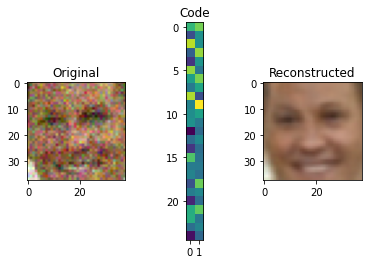

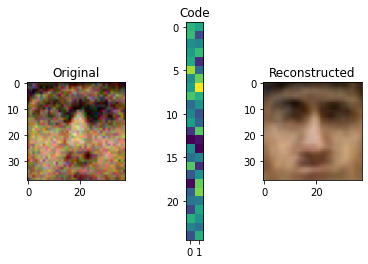

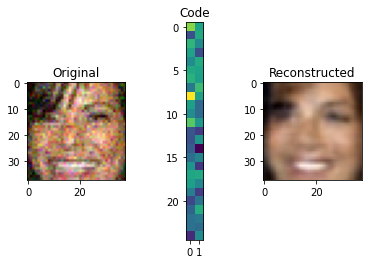

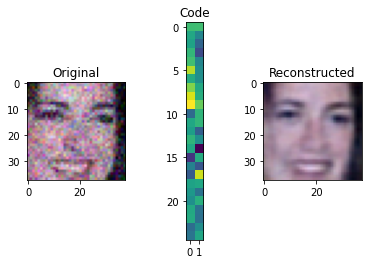

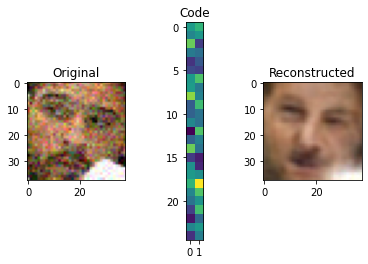

In [24]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print(X_test_tensor.size())
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise_sample(X_test_tensor[i])
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [25]:
device = torch.device("cuda")
aenc.to("cuda")

DeepAutoencoder(
  (enc): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LayerNorm((16, 38, 38), eps=1e-05, elementwise_affine=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): LayerNorm((16, 38, 38), eps=1e-05, elementwise_affine=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Reshape()
    (7): Linear(in_features=5776, out_features=700, bias=True)
    (8): ReLU()
    (9): Linear(in_features=700, out_features=50, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=50, out_features=700, bias=True)
    (1): ReLU()
    (2): Linear(in_features=700, out_features=5776, bias=True)
    (3): ReLU()
    (4): Reshape()
    (5): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
    (6): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LayerNorm((16, 38, 38), eps=1e-05, elementwise_affine=True)
    (8

In [35]:
#encodes batch of images into a codes

batch_size = 2000
codes = aenc.enc(X_train_tensor[:batch_size].cuda())


torch.Size([11828, 3, 38, 38])


In [28]:
assert codes.shape[0] == X_train_tensor[:batch_size].shape[0]

In [29]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors().fit(codes.detach().cpu().numpy())

In [30]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [41]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch, 3, height, width]"

    image = image[None, :]
    code = aenc.enc(image.cuda(device)).detach().cpu().numpy()
    (distances,),(idx,) = knn.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [39]:
def show_similar(image):
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

torch.Size([1, 3, 38, 38])


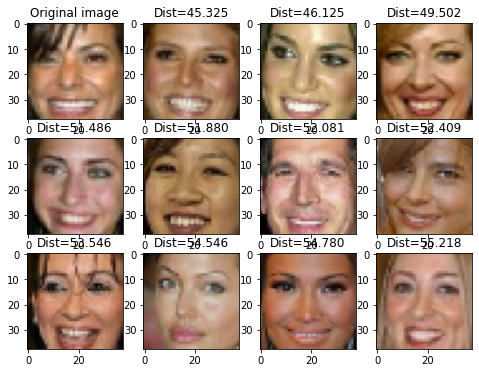

In [40]:
#smiles
show_similar(X_test_tensor[2])

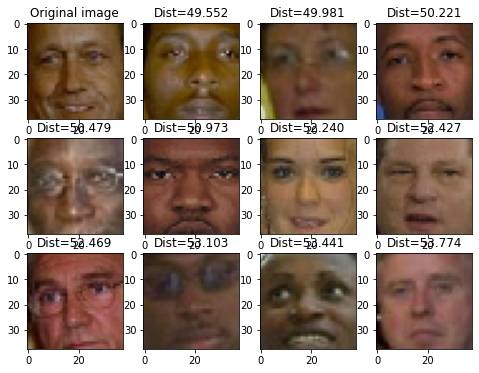

In [42]:
#ethnicity
show_similar(X_test_tensor[500])

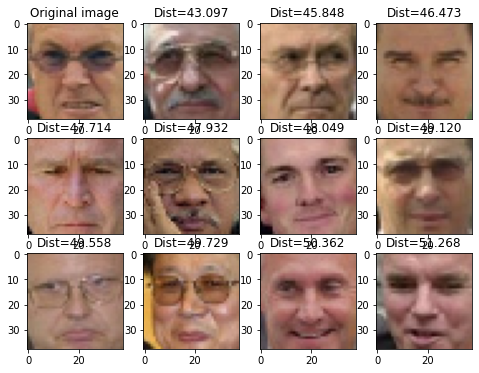

In [43]:
#glasses
show_similar(X_test_tensor[66])

## Bonus: cheap image morphing


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 38, 38])
torch.Size([50]) torch.Size([50])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])


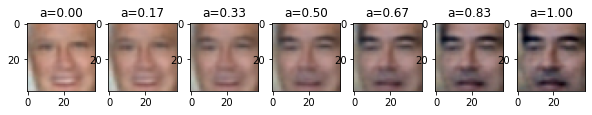

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 38, 38])
torch.Size([50]) torch.Size([50])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])


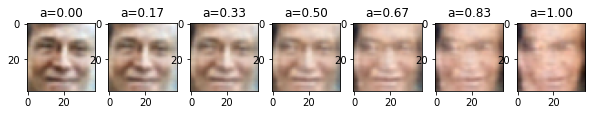

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 38, 38])
torch.Size([50]) torch.Size([50])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])


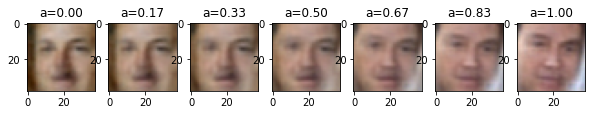

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 38, 38])
torch.Size([50]) torch.Size([50])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])


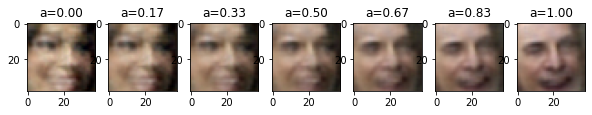

torch.Size([2, 3, 38, 38])
torch.Size([50]) torch.Size([50])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])
torch.Size([3, 38, 38])


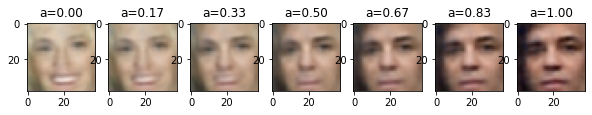

In [53]:

for _ in range(5):
    image1,image2 = X_test_tensor[np.random.randint(0,len(X_test),size=2)]

    image_pair = torch.cat([image1[None, :],image2[None, :]]).cuda(device)
    print(image_pair.size())
    # ^-- note: depending on your implementation, you may need to call torch.permute here
    
    
    code1, code2 = aenc.enc(image_pair)
    print(code1.size(), code2.size())

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = aenc.dec(output_code[None])[0]
        print(output_image.size())
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().numpy().transpose([1,2,0]))
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.
If you want to generate images from scratch, however, you're better off using generative adversarial networks.